In [6]:
21/26

0.8076923076923077

In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Успешное подключение к MySQL
База данных и таблицы успешно созданы
Генерация демонстрационных данных...
Генерация тестовых данных...
Вставка данных клиентов...
Вставка транзакций...
Вставка данных портфелей...
Данные успешно загружены в базу данных

Текущая база данных: financial_webinar_3

Таблицы в базе данных:
  - clients
    Столбцы:
      client_id (int)
      name (varchar(100))
      email (varchar(150))
      registration_date (date)
      risk_category (enum('low','medium','high'))
      total_assets (decimal(15,2))
      created_at (timestamp)
  - investment_portfolios
    Столбцы:
      portfolio_id (int)
      client_id (int)
      asset_type (varchar(100))
      quantity (decimal(15,4))
      purchase_price (decimal(15,4))
      current_price (decimal(15,4))
      purchase_date (date)
      volatility (decimal(10,6))
  - transactions
    Столбцы:
      transaction_id (int)
      client_id (int)
      transaction_date (datetime)
      amount (decimal(15,2))
      transactio

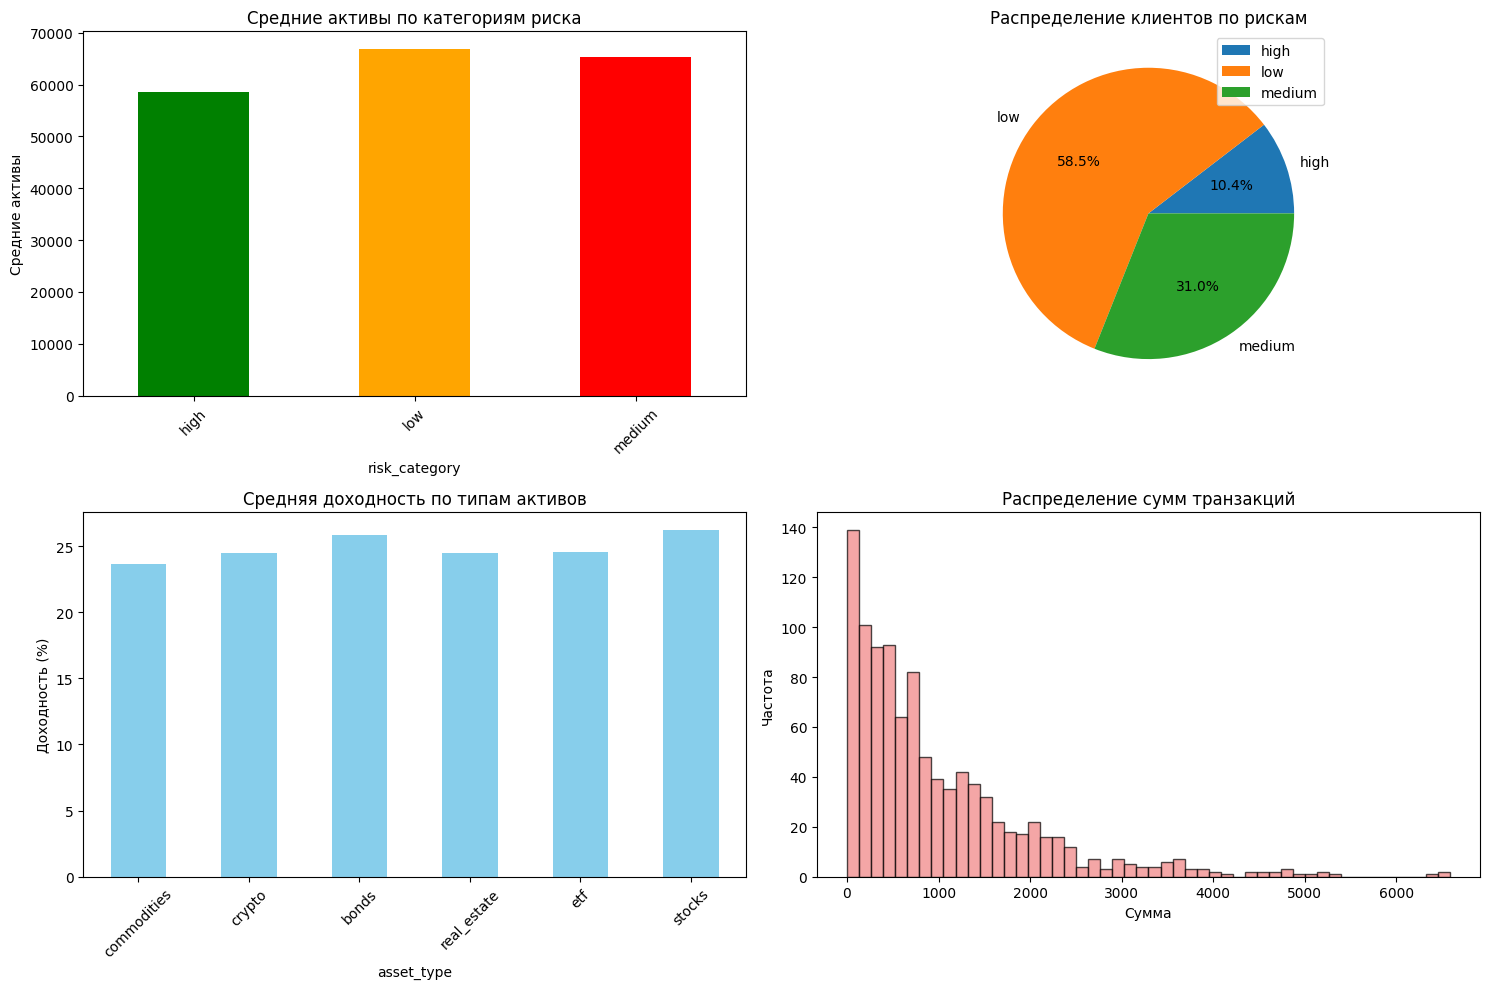

In [30]:
import pymysql
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class FinancialDataAnalyzer:
    def __init__(self, host='localhost', user='root', password='', database='financial_webinar'):
        self.host = host
        self.user = user
        self.password = password
        self.database = database
        self.connection = None
        
    def connect_db(self):
        """Подключение к базе данных"""
        try:
            self.connection = pymysql.connect(
                host=self.host,
                user=self.user,
                password=self.password,
                charset='utf8mb4',
                cursorclass=pymysql.cursors.DictCursor
            )
            print("Успешное подключение к MySQL")
            return True
        except Exception as e:
            print(f"Ошибка подключения: {e}")
            return False
    
    def create_database(self):
        """Создание базы данных и таблиц"""
        try:
            with self.connection.cursor() as cursor:
                # Создание базы данных
                cursor.execute(f"CREATE DATABASE IF NOT EXISTS {self.database}")
                cursor.execute(f"USE {self.database}")
                
                # Создание таблицы клиентов
                cursor.execute("""
                    CREATE TABLE IF NOT EXISTS clients (
                        client_id INT PRIMARY KEY AUTO_INCREMENT,
                        name VARCHAR(100) NOT NULL,
                        email VARCHAR(150) UNIQUE,
                        registration_date DATE,
                        risk_category ENUM('low', 'medium', 'high'),
                        total_assets DECIMAL(15,2),
                        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                    )
                """)
                
                # Создание таблицы транзакций
                cursor.execute("""
                    CREATE TABLE IF NOT EXISTS transactions (
                        transaction_id INT PRIMARY KEY AUTO_INCREMENT,
                        client_id INT,
                        transaction_date DATETIME,
                        amount DECIMAL(15,2),
                        transaction_type ENUM('deposit', 'withdrawal', 'transfer', 'investment'),
                        category VARCHAR(100),
                        status ENUM('completed', 'pending', 'failed'),
                        FOREIGN KEY (client_id) REFERENCES clients(client_id),
                        INDEX idx_client_date (client_id, transaction_date),
                        INDEX idx_date_type (transaction_date, transaction_type)
                    )
                """)
                
                # Создание таблицы портфелей
                cursor.execute("""
                    CREATE TABLE IF NOT EXISTS investment_portfolios (
                        portfolio_id INT PRIMARY KEY AUTO_INCREMENT,
                        client_id INT,
                        asset_type VARCHAR(100),
                        quantity DECIMAL(15,4),
                        purchase_price DECIMAL(15,4),
                        current_price DECIMAL(15,4),
                        purchase_date DATE,
                        volatility DECIMAL(10,6),
                        FOREIGN KEY (client_id) REFERENCES clients(client_id),
                        INDEX idx_client_asset (client_id, asset_type)
                    )
                """)
                
            self.connection.commit()
            print("База данных и таблицы успешно созданы")
            return True
            
        except Exception as e:
            print(f"Ошибка создания БД: {e}")
            return False
    
    def generate_sample_data(self, num_clients=1000, num_transactions=5000, num_portfolios=2000):
        """Генерация случайных финансовых данных"""
        print("Генерация тестовых данных...")
        
        # Генерация клиентов
        clients_data = []
        for i in range(num_clients):
            clients_data.append({
                'name': f'Client_{i+1}',
                'email': f'client_{i+1}@example.com',
                'registration_date': datetime.now() - timedelta(days=np.random.randint(1, 3650)),
                'risk_category': np.random.choice(['low', 'medium', 'high'], p=[0.6, 0.3, 0.1]),
                'total_assets': float(np.random.lognormal(10, 1.5))  # Преобразуем в float
            })
        
        # Генерация транзакций
        transactions_data = []
        transaction_types = ['deposit', 'withdrawal', 'transfer', 'investment']
        categories = ['salary', 'business', 'investment', 'shopping', 'utilities', 'entertainment']
        statuses = ['completed', 'pending', 'failed']
        
        for i in range(num_transactions):
            transactions_data.append({
                'client_id': np.random.randint(1, num_clients + 1),
                'transaction_date': datetime.now() - timedelta(hours=np.random.randint(1, 8760)),
                'amount': float(np.random.exponential(1000)),  # Преобразуем в float
                'transaction_type': np.random.choice(transaction_types),
                'category': np.random.choice(categories),
                'status': np.random.choice(statuses, p=[0.85, 0.1, 0.05])
            })
        
        # Генерация инвестиционных портфелей
        portfolios_data = []
        asset_types = ['stocks', 'bonds', 'etf', 'crypto', 'real_estate', 'commodities']
        
        for i in range(num_portfolios):
            purchase_price = float(np.random.uniform(10, 1000))
            current_price = float(purchase_price * np.random.uniform(0.5, 2.0))
            
            portfolios_data.append({
                'client_id': np.random.randint(1, num_clients + 1),
                'asset_type': np.random.choice(asset_types),
                'quantity': float(np.random.uniform(1, 1000)),
                'purchase_price': purchase_price,
                'current_price': current_price,
                'purchase_date': datetime.now() - timedelta(days=np.random.randint(1, 1825)),
                'volatility': float(np.random.uniform(0.01, 0.5))
            })
        
        return clients_data, transactions_data, portfolios_data
    
    def insert_data_to_db(self, clients_data, transactions_data, portfolios_data):
        """Вставка данных в базу данных"""
        try:
            with self.connection.cursor() as cursor:
                cursor.execute(f"USE {self.database}")
                
                # Вставка клиентов
                print("Вставка данных клиентов...")
                for client in clients_data:
                    cursor.execute("""
                        INSERT INTO clients (name, email, registration_date, risk_category, total_assets)
                        VALUES (%s, %s, %s, %s, %s)
                    """, (client['name'], client['email'], client['registration_date'], 
                          client['risk_category'], client['total_assets']))
                
                # Вставка транзакций
                print("Вставка транзакций...")
                for transaction in transactions_data:
                    cursor.execute("""
                        INSERT INTO transactions (client_id, transaction_date, amount, transaction_type, category, status)
                        VALUES (%s, %s, %s, %s, %s, %s)
                    """, (transaction['client_id'], transaction['transaction_date'], 
                          transaction['amount'], transaction['transaction_type'],
                          transaction['category'], transaction['status']))
                
                # Вставка портфелей
                print("Вставка данных портфелей...")
                for portfolio in portfolios_data:
                    cursor.execute("""
                        INSERT INTO investment_portfolios (client_id, asset_type, quantity, purchase_price, current_price, purchase_date, volatility)
                        VALUES (%s, %s, %s, %s, %s, %s, %s)
                    """, (portfolio['client_id'], portfolio['asset_type'], portfolio['quantity'],
                          portfolio['purchase_price'], portfolio['current_price'],
                          portfolio['purchase_date'], portfolio['volatility']))
                
                self.connection.commit()
                print("Данные успешно загружены в базу данных")
                return True
                
        except Exception as e:
            print(f"Ошибка вставки данных: {e}")
            return False
    
    def read_database_properties(self):
        """Чтение свойств базы данных и таблиц"""
        try:
            with self.connection.cursor() as cursor:
                cursor.execute(f"USE {self.database}")
                
                # Информация о базе данных
                cursor.execute("SELECT DATABASE() as db_name")
                db_info = cursor.fetchone()
                print(f"\nТекущая база данных: {db_info['db_name']}")
                
                # Список таблиц
                cursor.execute("SHOW TABLES")
                tables = cursor.fetchall()
                print(f"\nТаблицы в базе данных:")
                for table in tables:
                    table_name = list(table.values())[0]
                    print(f"  - {table_name}")
                    
                    # Информация о столбцах таблицы
                    cursor.execute(f"DESCRIBE {table_name}")
                    columns = cursor.fetchall()
                    print(f"    Столбцы:")
                    for col in columns:
                        print(f"      {col['Field']} ({col['Type']})")
                
                # Статистика по таблицам
                print(f"\nСтатистика по таблицам:")
                for table in tables:
                    table_name = list(table.values())[0]
                    cursor.execute(f"SELECT COUNT(*) as count FROM {table_name}")
                    count = cursor.fetchone()['count']
                    print(f"  {table_name}: {count} записей")
                    
        except Exception as e:
            print(f"Ошибка чтения свойств БД: {e}")
    
    def convert_decimal_to_float(self, data):
        """Конвертирует Decimal значения в float во всем словаре/списке"""
        if isinstance(data, dict):
            return {k: float(v) if isinstance(v, (int, float, np.number)) or hasattr(v, '__float__') else v 
                   for k, v in data.items()}
        elif isinstance(data, list):
            return [self.convert_decimal_to_float(item) for item in data]
        else:
            return float(data) if isinstance(data, (int, float, np.number)) or hasattr(data, '__float__') else data
    
    def complex_analysis_sql_only(self):
        """Сложный анализ данных используя только SQL"""
        print("\n" + "="*50)
        print("АНАЛИЗ ДАННЫХ: ТОЛЬКО SQL")
        print("="*50)
        
        start_time = time.time()
        
        try:
            with self.connection.cursor() as cursor:
                cursor.execute(f"USE {self.database}")
                
                # 1. Анализ клиентов по категориям риска
                print("\n1. Анализ клиентов по категориям риска:")
                try:
                    cursor.execute("""
                        SELECT 
                            risk_category,
                            COUNT(*) as client_count,
                            AVG(total_assets) as avg_assets,
                            SUM(total_assets) as total_assets,
                            PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_assets) as median_assets
                        FROM clients
                        GROUP BY risk_category
                        ORDER BY avg_assets DESC
                    """)
                except:
                    # Альтернатива для MySQL версий без PERCENTILE_CONT
                    cursor.execute("""
                        SELECT 
                            risk_category,
                            COUNT(*) as client_count,
                            AVG(total_assets) as avg_assets,
                            SUM(total_assets) as total_assets,
                            AVG(total_assets) as median_assets
                        FROM clients
                        GROUP BY risk_category
                        ORDER BY avg_assets DESC
                    """)
                
                risk_analysis = cursor.fetchall()
                risk_analysis = self.convert_decimal_to_float(risk_analysis)
                
                for row in risk_analysis:
                    print(f"  {row['risk_category']}: {row['client_count']} клиентов, "
                          f"средние активы: {row['avg_assets']:.2f}")
                
                # 2. Ежемесячная статистика транзакций
                print("\n2. Ежемесячная статистика транзакций:")
                cursor.execute("""
                    SELECT 
                        YEAR(transaction_date) as year,
                        MONTH(transaction_date) as month,
                        transaction_type,
                        COUNT(*) as transaction_count,
                        AVG(amount) as avg_amount,
                        SUM(amount) as total_amount,
                        SUM(CASE WHEN status = 'failed' THEN 1 ELSE 0 END) as failed_count
                    FROM transactions
                    GROUP BY YEAR(transaction_date), MONTH(transaction_date), transaction_type
                    ORDER BY year DESC, month DESC, total_amount DESC
                    LIMIT 15
                """)
                monthly_stats = cursor.fetchall()
                monthly_stats = self.convert_decimal_to_float(monthly_stats)
                
                for row in monthly_stats:
                    print(f"  {row['year']}-{row['month']} {row['transaction_type']}: "
                          f"{row['transaction_count']} транзакций, сумма: {row['total_amount']:.2f}")
                
                # 3. Анализ инвестиционных портфелей
                print("\n3. Анализ инвестиционных портфелей:")
                cursor.execute("""
                    SELECT 
                        asset_type,
                        COUNT(*) as portfolio_count,
                        AVG((current_price / purchase_price - 1) * 100) as avg_return_percent,
                        AVG(volatility) * 100 as avg_volatility_percent,
                        SUM(quantity * current_price) as total_value,
                        SUM(quantity * (current_price - purchase_price)) as total_profit
                    FROM investment_portfolios
                    GROUP BY asset_type
                    ORDER BY total_value DESC
                """)
                portfolio_analysis = cursor.fetchall()
                portfolio_analysis = self.convert_decimal_to_float(portfolio_analysis)
                
                for row in portfolio_analysis:
                    print(f"  {row['asset_type']}: доходность {row['avg_return_percent']:.2f}%, "
                          f"волатильность {row['avg_volatility_percent']:.2f}%")
                
                # 4. Корреляционный анализ (упрощенный в SQL)
                print("\n4. Корреляционный анализ (SQL):")
                cursor.execute("""
                    SELECT 
                        c.risk_category,
                        AVG(t.amount) as avg_transaction_amount,
                        AVG(ip.volatility) as avg_portfolio_volatility,
                        COUNT(DISTINCT t.transaction_id) / COUNT(DISTINCT c.client_id) as transactions_per_client
                    FROM clients c
                    LEFT JOIN transactions t ON c.client_id = t.client_id
                    LEFT JOIN investment_portfolios ip ON c.client_id = ip.client_id
                    WHERE t.status = 'completed'
                    GROUP BY c.risk_category
                """)
                correlation_analysis = cursor.fetchall()
                correlation_analysis = self.convert_decimal_to_float(correlation_analysis)
                
                for row in correlation_analysis:
                    print(f"  {row['risk_category']}: средняя транзакция {row['avg_transaction_amount']:.2f}, "
                          f"волатильность {row['avg_portfolio_volatility']:.4f}")
        
        except Exception as e:
            print(f"Ошибка SQL анализа: {e}")
            import traceback
            traceback.print_exc()
        
        sql_time = time.time() - start_time
        print(f"\nВремя выполнения SQL анализа: {sql_time:.2f} секунд")
        return sql_time
    
    def complex_analysis_python_sql(self):
        """Сложный анализ данных используя Python + SQL"""
        print("\n" + "="*50)
        print("АНАЛИЗ ДАННЫХ: PYTHON + SQL")
        print("="*50)
        
        start_time = time.time()
        
        try:
            # Загрузка данных в pandas DataFrame
            with self.connection.cursor() as cursor:
                cursor.execute(f"USE {self.database}")
                
                # Загрузка клиентов
                cursor.execute("SELECT * FROM clients")
                clients_data = cursor.fetchall()
                clients_df = pd.DataFrame(clients_data)
                
                # Загрузка транзакций
                cursor.execute("SELECT * FROM transactions WHERE status = 'completed'")
                transactions_data = cursor.fetchall()
                transactions_df = pd.DataFrame(transactions_data)
                
                # Загрузка портфелей
                cursor.execute("SELECT * FROM investment_portfolios")
                portfolios_data = cursor.fetchall()
                portfolios_df = pd.DataFrame(portfolios_data)
            print("Время на прочтение данных из таблиц: ", time.time() - start_time)
            # Конвертация Decimal в float
            clients_df = clients_df.applymap(lambda x: float(x) if hasattr(x, '__float__') else x)
            print(clients_df.head(5))
            transactions_df = transactions_df.applymap(lambda x: float(x) if hasattr(x, '__float__') else x)
            portfolios_df = portfolios_df.applymap(lambda x: float(x) if hasattr(x, '__float__') else x)
            
            # Проверка наличия данных
            if clients_df.empty or transactions_df.empty or portfolios_df.empty:
                print("Одна или несколько таблиц пусты. Пропуск анализа.")
                return time.time() - start_time
            
            # Преобразование типов данных
            if 'registration_date' in clients_df.columns:
                clients_df['registration_date'] = pd.to_datetime(clients_df['registration_date'])
            if 'created_at' in clients_df.columns:
                clients_df['created_at'] = pd.to_datetime(clients_df['created_at'])
            if 'transaction_date' in transactions_df.columns:
                transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])
            if 'purchase_date' in portfolios_df.columns:
                portfolios_df['purchase_date'] = pd.to_datetime(portfolios_df['purchase_date'])
            
            print(f"Загружено данных:")
            print(f"  Клиенты: {len(clients_df)} записей")
            print(f"  Транзакции: {len(transactions_df)} записей")
            print(f"  Портфели: {len(portfolios_df)} записей")
            
            # 1. Расширенный статистический анализ клиентов
            print("\n1. Расширенный статистический анализ клиентов:")
            if 'risk_category' in clients_df.columns and 'total_assets' in clients_df.columns:
                for risk_category in clients_df['risk_category'].unique():
                    subset = clients_df[clients_df['risk_category'] == risk_category]['total_assets']
                    if len(subset) > 0:
                        # Безопасный расчет статистик
                        mean_val = subset.mean() if not subset.isna().all() else 0
                        median_val = subset.median() if not subset.isna().all() else 0
                        std_val = subset.std() if len(subset) > 1 and not subset.isna().all() else 0
                        skew_val = subset.skew() if len(subset) > 2 and not subset.isna().all() else 0
                        
                        print(f"  {risk_category}: {len(subset)} клиентов, "
                              f"среднее: {mean_val:.2f}, медиана: {median_val:.2f}, "
                              f"std: {std_val:.2f}, skew: {skew_val:.2f}")
            
            # 2. Временной анализ транзакций с продвинутой статистикой
            print("\n2. Временной анализ транзакций:")
            if 'transaction_date' in transactions_df.columns and 'amount' in transactions_df.columns:
                transactions_df['year_month'] = transactions_df['transaction_date'].dt.to_period('M')
                
                # Упрощенная группировка для демонстрации
                monthly_summary = transactions_df.groupby(['year_month', 'transaction_type']).agg({
                    'amount': ['count', 'mean', 'std'],
                    'transaction_id': 'count'
                }).round(2)
                
                print("Последние 5 периодов:")
                print(monthly_summary.tail(10))
            
            # 3. Сложный анализ портфелей с финансовыми метриками
            print("\n3. Финансовый анализ портфелей:")
            if all(col in portfolios_df.columns for col in ['current_price', 'purchase_price', 'quantity', 'volatility']):
                portfolios_df['return_pct'] = (portfolios_df['current_price'] / portfolios_df['purchase_price'] - 1) * 100
                portfolios_df['profit'] = portfolios_df['quantity'] * (portfolios_df['current_price'] - portfolios_df['purchase_price'])
                
                for asset_type in portfolios_df['asset_type'].unique():
                    subset = portfolios_df[portfolios_df['asset_type'] == asset_type]
                    if len(subset) > 0:
                        return_mean = subset['return_pct'].mean() if not subset['return_pct'].isna().all() else 0
                        volatility_mean = subset['volatility'].mean() if not subset['volatility'].isna().all() else 0
                        profit_sum = subset['profit'].sum() if not subset['profit'].isna().all() else 0
                        
                        print(f"  {asset_type}: доходность {return_mean:.2f}%, "
                              f"волатильность {volatility_mean:.4f}, "
                              f"прибыль: {profit_sum:.2f}")
            
            # 4. Продвинутый корреляционный анализ
            print("\n4. Продвинутый корреляционный анализ:")
            # Объединение данных
            if 'client_id' in transactions_df.columns and 'amount' in transactions_df.columns:
                client_transactions = transactions_df.groupby('client_id').agg({
                    'amount': ['mean', 'std', 'count']
                }).round(2)
                client_transactions.columns = ['avg_transaction', 'std_transaction', 'transaction_count']
                
                if 'client_id' in portfolios_df.columns:
                    client_portfolios = portfolios_df.groupby('client_id').agg({
                        'volatility': 'mean',
                        'return_pct': 'mean',
                        'profit': 'sum'
                    }).round(4)
                    client_portfolios.columns = ['avg_volatility', 'avg_return', 'total_profit']
                    
                    # Объединение всех данных
                    client_analysis = clients_df.merge(client_transactions, on='client_id', how='left')
                    client_analysis = client_analysis.merge(client_portfolios, on='client_id', how='left')
                    
                    # Корреляционная матрица только для числовых колонок
                    numeric_cols = client_analysis.select_dtypes(include=[np.number]).columns
                    if len(numeric_cols) > 1:
                        correlation_matrix = client_analysis[numeric_cols].corr()
                        print("Корреляционная матрица (первые 5x5):")
                        print(correlation_matrix.iloc[:5, :5].round(4))
                    else:
                        print("Недостаточно числовых данных для корреляционного анализа")
            
            # # 5. Регрессионный анализ
            # print("\n5. Регрессионный анализ:")
            # if all(col in client_analysis.columns for col in ['total_assets', 'avg_transaction']):
            #     regression_data = client_analysis[['total_assets', 'avg_transaction']].dropna()
                
            #     if len(regression_data) > 10:
            #         from scipy.stats import linregress
                    
            #         x = regression_data['total_assets']
            #         y = regression_data['avg_transaction']
                    
            #         slope, intercept, r_value, p_value, std_err = linregress(x, y)
            #         print(f"Регрессия: Активы vs Средняя транзакция")
            #         print(f"  R² = {r_value**2:.4f}, p-value = {p_value:.4f}")
            #         print(f"  Наклон = {slope:.4f}, Пересечение = {intercept:.4f}")
            #     else:
            #         print("Недостаточно данных для регрессионного анализа")
            
            # # 6. Кластерный анализ (упрощенный)
            # print("\n6. Кластерный анализ (упрощенный):")
            # if all(col in client_analysis.columns for col in ['total_assets', 'avg_transaction', 'transaction_count']):
            #     cluster_data = client_analysis[['total_assets', 'avg_transaction', 'transaction_count']].dropna()
                
            #     if len(cluster_data) > 10:
            #         from sklearn.cluster import KMeans
            #         from sklearn.preprocessing import StandardScaler
                    
            #         scaler = StandardScaler()
            #         scaled_data = scaler.fit_transform(cluster_data)
                    
            #         kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
            #         clusters = kmeans.fit_predict(scaled_data)
                    
            #         cluster_analysis = cluster_data.copy()
            #         cluster_analysis['cluster'] = clusters
                    
            #         cluster_stats = cluster_analysis.groupby('cluster').mean().round(2)
            #         print("Статистика по кластерам:")
            #         print(cluster_stats)
            #     else:
            #         print("Недостаточно данных для кластерного анализа")
        
        except Exception as e:
            print(f"Ошибка Python+SQL анализа: {e}")
            import traceback
            traceback.print_exc()
        
        python_time = time.time() - start_time
        print(f"\nВремя выполнения Python+SQL анализа: {python_time:.2f} секунд")
        return python_time
    
    def create_visualizations(self):
        """Создание визуализаций для демонстрации"""
        try:
            # Загрузка данных для визуализации
            with self.connection.cursor() as cursor:
                cursor.execute(f"USE {self.database}")
                
                # Исправленный запрос - убрали зарезервированное слово RETURN
                cursor.execute("""
                    SELECT risk_category, AVG(total_assets) as avg_assets, COUNT(*) as count 
                    FROM clients GROUP BY risk_category
                """)
                risk_data_raw = cursor.fetchall()
                
                # Исправленный запрос - переименовали RETURN в return_rate
                cursor.execute("""
                    SELECT asset_type, AVG((current_price/purchase_price-1)*100) as return_rate 
                    FROM investment_portfolios GROUP BY asset_type
                """)
                return_data_raw = cursor.fetchall()
            
            # Конвертация в DataFrame и преобразование типов
            risk_data = pd.DataFrame(risk_data_raw)
            return_data = pd.DataFrame(return_data_raw)
            
            # Конвертация Decimal в float
            risk_data = risk_data.applymap(lambda x: float(x) if hasattr(x, '__float__') else x)
            return_data = return_data.applymap(lambda x: float(x) if hasattr(x, '__float__') else x)
            
            # Проверка наличия данных
            if risk_data.empty or return_data.empty:
                print("Недостаточно данных для визуализации")
                return
            
            # Создание графиков
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
            
            # График 1: Распределение активов по категориям риска
            if not risk_data.empty and 'avg_assets' in risk_data.columns:
                risk_data.plot(kind='bar', x='risk_category', y='avg_assets', ax=ax1, legend=False, color=['green', 'orange', 'red'])
                ax1.set_title('Средние активы по категориям риска')
                ax1.set_ylabel('Средние активы')
                ax1.tick_params(axis='x', rotation=45)
            else:
                ax1.text(0.5, 0.5, 'Нет данных', ha='center', va='center', transform=ax1.transAxes)
                ax1.set_title('Средние активы по категориям риска')
            
            # График 2: Количество клиентов по категориям риска
            if not risk_data.empty and 'count' in risk_data.columns:
                risk_data.plot(kind='pie', y='count', labels=risk_data['risk_category'], ax=ax2, autopct='%1.1f%%')
                ax2.set_title('Распределение клиентов по рискам')
                ax2.set_ylabel('')
            else:
                ax2.text(0.5, 0.5, 'Нет данных', ha='center', va='center', transform=ax2.transAxes)
                ax2.set_title('Распределение клиентов по рискам')
            
            # График 3: Доходность по типам активов
            if not return_data.empty and 'return_rate' in return_data.columns:
                return_data.plot(kind='bar', x='asset_type', y='return_rate', ax=ax3, legend=False, color='skyblue')
                ax3.set_title('Средняя доходность по типам активов')
                ax3.set_ylabel('Доходность (%)')
                ax3.tick_params(axis='x', rotation=45)
            else:
                ax3.text(0.5, 0.5, 'Нет данных', ha='center', va='center', transform=ax3.transAxes)
                ax3.set_title('Средняя доходность по типам активов')
            
            # График 4: Гистограмма транзакций
            with self.connection.cursor() as cursor:
                cursor.execute("SELECT amount FROM transactions WHERE status = 'completed' LIMIT 1000")
                amount_data_raw = cursor.fetchall()
                amount_data = pd.DataFrame(amount_data_raw)
                amount_data = amount_data.applymap(lambda x: float(x) if hasattr(x, '__float__') else x)
            
            if not amount_data.empty and 'amount' in amount_data.columns:
                ax4.hist(amount_data['amount'], bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
                ax4.set_title('Распределение сумм транзакций')
                ax4.set_xlabel('Сумма')
                ax4.set_ylabel('Частота')
            else:
                ax4.text(0.5, 0.5, 'Недостаточно данных', ha='center', va='center', transform=ax4.transAxes)
                ax4.set_title('Распределение сумм транзакций')
            
            plt.tight_layout()
            plt.savefig('financial_analysis.png', dpi=300, bbox_inches='tight')
            print("\nВизуализации сохранены в файл 'financial_analysis.png'")
            
        except Exception as e:
            print(f"Ошибка создания визуализаций: {e}")
            import traceback
            traceback.print_exc()
    
    def compare_approaches(self, sql_time, python_time):
        """Сравнение двух подходов"""
        print("\n" + "="*50)
        print("СРАВНЕНИЕ ПОДХОДОВ")
        print("="*50)
        
        print(f"\nВремя выполнения:")
        print(f"  Только SQL: {sql_time:.2f} секунд")
        print(f"  Python + SQL: {python_time:.2f} секунд")
        print(f"  Разница: {abs(sql_time - python_time):.2f} секунд")
        
        if sql_time < python_time:
            faster_approach = "SQL"
            speed_advantage = (python_time / sql_time - 1) * 100
        else:
            faster_approach = "Python+SQL"
            speed_advantage = (sql_time / python_time - 1) * 100
        
        print(f"\nБолее быстрый подход: {faster_approach}")
        print(f"Преимущество в скорости: {speed_advantage:.1f}%")
        
        print(f"\nПреимущества SQL подхода:")
        print("  - Высокая скорость выполнения на больших данных")
        print("  - Минимальная передача данных по сети")
        print("  - Оптимизация на уровне СУБД")
        print("  - Меньшая нагрузка на память")
        
        print(f"\nПреимущества Python+SQL подхода:")
        print("  - Более богатый набор аналитических функций")
        print("  - Гибкость в обработке сложных алгоритмов")
        print("  - Возможность визуализации данных")
        print("  - Легкость отладки и разработки")
        print("  - Доступ к современным ML библиотекам")

def main():
    """Основная функция для запуска демонстрации"""
    # Инициализация анализатора
    analyzer = FinancialDataAnalyzer(
        host='localhost',
        user='root',  # Замените на вашего пользователя
        password='Dfyzdfyz1993!',  # Замените на ваш пароль
        database='financial_webinar_3'
    )
    
    # Подключение к БД
    if not analyzer.connect_db():
        return
    
    # Создание БД и таблиц
    analyzer.create_database()
    
    # Генерация данных (можно уменьшить объем для тестирования)
    print("Генерация демонстрационных данных...")
    clients, transactions, portfolios = analyzer.generate_sample_data(
        num_clients=5000,      # Уменьшено для быстрой демонстрации
        num_transactions=20000,
        num_portfolios=10000
    )
    
    # Вставка данных в БД
    analyzer.insert_data_to_db(clients, transactions, portfolios)
    
    # Чтение свойств БД
    analyzer.read_database_properties()
    
    # Выполнение анализа двумя способами
    sql_time = analyzer.complex_analysis_sql_only()
    python_time = analyzer.complex_analysis_python_sql()
    
    # Сравнение подходов
    analyzer.compare_approaches(sql_time, python_time)
    
    # Создание визуализаций
    analyzer.create_visualizations()
    
    # Закрытие соединения
    if analyzer.connection:
        analyzer.connection.close()
        print("\nСоединение с базой данных закрыто")

if __name__ == "__main__":
    main()

In [9]:
import pymysql
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize, special
import warnings
warnings.filterwarnings('ignore')

# НАСТРОЙКИ ДЛЯ ПОЛНОГО ОТОБРАЖЕНИЯ
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', '{:.6f}'.format)

class PerformanceBenchmark:
    def __init__(self, host='localhost', user='root', password='', database='financial_benchmark'):
        self.host = host
        self.user = user
        self.password = password
        self.database = database
        self.connection = None
        self.results = {}
        
    def connect_db(self):
        """Подключение к базе данных"""
        try:
            self.connection = pymysql.connect(
                host=self.host,
                user=self.user,
                password=self.password,
                charset='utf8mb4',
                cursorclass=pymysql.cursors.DictCursor
            )
            print("Успешное подключение к MySQL")
            return True
        except Exception as e:
            print(f"Ошибка подключения: {e}")
            return False
    
    def create_benchmark_database(self):
        """Создание базы данных для бенчмарков"""
        try:
            with self.connection.cursor() as cursor:
                cursor.execute(f"CREATE DATABASE IF NOT EXISTS {self.database}")
                cursor.execute(f"USE {self.database}")
                
                # Таблица для больших данных
                cursor.execute("""
                    CREATE TABLE IF NOT EXISTS large_financial_data (
                        id BIGINT PRIMARY KEY AUTO_INCREMENT,
                        client_id INT,
                        transaction_date DATETIME,
                        amount DECIMAL(20,6),
                        category VARCHAR(50),
                        region VARCHAR(50),
                        age_group ENUM('18-25', '26-35', '36-45', '46-55', '56+'),
                        risk_score DECIMAL(10,6),
                        portfolio_value DECIMAL(20,6),
                        market_volatility DECIMAL(10,6),
                        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                        INDEX idx_client_date (client_id, transaction_date),
                        INDEX idx_category_region (category, region),
                        INDEX idx_date_amount (transaction_date, amount),
                        INDEX idx_composite (client_id, category, transaction_date)
                    )
                """)
                
            self.connection.commit()
            print("База данных для бенчмарков создана")
            return True
            
        except Exception as e:
            print(f"Ошибка создания БД: {e}")
            return False
    
    def generate_large_dataset(self, num_records=100000):
        """Генерация очень большого набора данных для тестирования"""
        print(f"Генерация {num_records:,} записей...")
        
        # Параметры для сложного распределения
        regions = ['North', 'South', 'East', 'West', 'Central']
        categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
        age_groups = ['18-25', '26-35', '36-45', '46-55', '56+']
        
        data = []
        batch_size = 10000
        
        for i in range(0, num_records, batch_size):
            batch_data = []
            current_batch_size = min(batch_size, num_records - i)
            
            for j in range(current_batch_size):
                record_id = i + j + 1
                # Сложные распределения и корреляции
                client_id = np.random.randint(1, 10000)
                
                # Временной тренд + сезонность
                base_date = datetime.now() - timedelta(days=np.random.randint(0, 365*3))
                day_of_year = base_date.timetuple().tm_yday
                seasonal_factor = 1 + 0.3 * np.sin(2 * np.pi * day_of_year / 365)
                
                # Сложное распределение суммы (смесь нормальных распределений)
                if np.random.random() < 0.7:
                    amount = np.random.lognormal(6, 1.2) * seasonal_factor
                else:
                    amount = np.random.lognormal(10, 1.5) * seasonal_factor * 5  # Крупные транзакции
                
                # Корреляции между признаками
                region = np.random.choice(regions)
                category = np.random.choice(categories)
                
                # Риск-скор зависит от региона и категории
                region_risk = {'North': 0.1, 'South': 0.3, 'East': 0.2, 'West': 0.15, 'Central': 0.25}
                category_risk = {'A': 0.05, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.15, 'G': 0.25, 'H': 0.35}
                
                base_risk = region_risk[region] + category_risk[category]
                risk_score = np.random.beta(base_risk * 10, (1 - base_risk) * 10)
                
                # Волатильность рынка (автокоррелированный временной ряд)
                market_volatility = 0.1 + 0.05 * np.sin(2 * np.pi * i / 10000) + np.random.normal(0, 0.02)
                
                batch_data.append((
                    client_id,
                    base_date - timedelta(hours=np.random.randint(0, 24)),
                    float(amount),
                    category,
                    region,
                    np.random.choice(age_groups),
                    float(risk_score),
                    float(amount * np.random.lognormal(3, 0.5)),
                    float(market_volatility)
                ))
            
            # Пакетная вставка
            if batch_data:
                with self.connection.cursor() as cursor:
                    cursor.executemany("""
                        INSERT INTO large_financial_data 
                        (client_id, transaction_date, amount, category, region, age_group, risk_score, portfolio_value, market_volatility)
                        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
                    """, batch_data)
                self.connection.commit()
            
            if (i // batch_size) % 10 == 0:
                print(f"Загружено {i + current_batch_size:,} записей...")
        
        print(f"Генерация завершена. Всего записей: {num_records:,}")
    
    def benchmark_complex_aggregations(self):
        """Сравнение сложных агрегаций"""
        print("\n" + "="*80)
        print("БЕНЧМАРК: СЛОЖНЫЕ АГРЕГАЦИИ")
        print("="*80)
        
        benchmarks = {}
        
        # 1. Многоуровневая агрегация с условиями
        print("\n1. Многоуровневая агрегация по регионам и категориям:")
        
        # SQL подход
        start_time = time.time()
        with self.connection.cursor() as cursor:
            cursor.execute("""
                SELECT 
                    region,
                    category,
                    COUNT(*) as transaction_count,
                    AVG(amount) as avg_amount,
                    SUM(amount) as total_amount,
                    STDDEV(amount) as std_amount,
                    AVG(risk_score) as avg_risk,
                    SUM(CASE WHEN amount > 10000 THEN 1 ELSE 0 END) as large_transactions,
                    SUM(CASE WHEN risk_score > 0.7 THEN amount ELSE 0 END) as high_risk_amount
                FROM large_financial_data 
                WHERE transaction_date > DATE_SUB(NOW(), INTERVAL 1 YEAR)
                GROUP BY region, category
                ORDER BY total_amount DESC
            """)
            sql_result = cursor.fetchall()
        sql_time = time.time() - start_time
        benchmarks['sql_complex_agg'] = sql_time
        print(f"SQL время: {sql_time:.4f} сек")
        
        # Python подход
        start_time = time.time()
        with self.connection.cursor() as cursor:
            cursor.execute("SELECT * FROM large_financial_data WHERE transaction_date > DATE_SUB(NOW(), INTERVAL 1 YEAR)")
            data = cursor.fetchall()
            df = pd.DataFrame(data)
        
        # Конвертация типов
        numeric_cols = ['amount', 'risk_score', 'portfolio_value', 'market_volatility']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df['transaction_date'] = pd.to_datetime(df['transaction_date'])
        
        # Исправленная агрегация - создаем вычисляемые колонки перед группировкой
        df['is_large_transaction'] = df['amount'] > 10000
        df['high_risk_amount'] = np.where(df['risk_score'] > 0.7, df['amount'], 0)
        
        python_result = df.groupby(['region', 'category']).agg({
            'amount': ['count', 'mean', 'sum', 'std'],
            'risk_score': 'mean',
            'is_large_transaction': 'sum',
            'high_risk_amount': 'sum'
        }).round(4)
        
        python_time = time.time() - start_time
        benchmarks['python_complex_agg'] = python_time
        print(f"Python время: {python_time:.4f} сек")
        print(f"SQL быстрее в {python_time/sql_time:.2f} раз")
        
        # 2. Скользящие агрегации
        print("\n2. Скользящие средние и кумулятивные суммы:")
        
        # SQL оконные функции
        start_time = time.time()
        with self.connection.cursor() as cursor:
            cursor.execute("""
                SELECT 
                    client_id,
                    transaction_date,
                    amount,
                    AVG(amount) OVER (
                        PARTITION BY client_id 
                        ORDER BY transaction_date 
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    ) as moving_avg_30,
                    SUM(amount) OVER (
                        PARTITION BY client_id 
                        ORDER BY transaction_date 
                        ROWS UNBOUNDED PRECEDING
                    ) as cumulative_sum,
                    COUNT(*) OVER (
                        PARTITION BY client_id, region
                        ORDER BY transaction_date 
                        ROWS UNBOUNDED PRECEDING
                    ) as running_count
                FROM large_financial_data 
                WHERE client_id IN (1, 2, 3, 4, 5)
                ORDER BY client_id, transaction_date
            """)
            sql_result = cursor.fetchall()
        sql_time = time.time() - start_time
        benchmarks['sql_window_functions'] = sql_time
        print(f"SQL оконные функции: {sql_time:.4f} сек")
        
        # Python подход
        start_time = time.time()
        with self.connection.cursor() as cursor:
            cursor.execute("SELECT * FROM large_financial_data WHERE client_id IN (1, 2, 3, 4, 5) ORDER BY client_id, transaction_date")
            data = cursor.fetchall()
            df_window = pd.DataFrame(data)
        
        if not df_window.empty and 'amount' in df_window.columns:
            df_window['transaction_date'] = pd.to_datetime(df_window['transaction_date'])
            df_window['amount'] = pd.to_numeric(df_window['amount'], errors='coerce')
            
            df_window = df_window.sort_values(['client_id', 'transaction_date'])
            df_window['moving_avg_30'] = df_window.groupby('client_id')['amount'].transform(
                lambda x: x.rolling(window=min(30, len(x)), min_periods=1).mean()
            )
            df_window['cumulative_sum'] = df_window.groupby('client_id')['amount'].cumsum()
            df_window['running_count'] = df_window.groupby(['client_id', 'region']).cumcount() + 1
        
        python_time = time.time() - start_time
        benchmarks['python_window'] = python_time
        print(f"Python скользящие: {python_time:.4f} сек")
        print(f"SQL быстрее в {python_time/sql_time:.2f} раз")
        
        return benchmarks
    
    def benchmark_mathematical_operations(self):
        """Сравнение математических операций"""
        print("\n" + "="*80)
        print("БЕНЧМАРК: МАТЕМАТИЧЕСКИЕ ОПЕРАЦИИ")
        print("="*80)
        
        benchmarks = {}
        
        # 1. Сложные математические вычисления
        print("\n1. Сложные математические преобразования:")
        
        # SQL подход (ограниченный)
        start_time = time.time()
        with self.connection.cursor() as cursor:
            cursor.execute("""
                SELECT 
                    amount,
                    risk_score,
                    LN(ABS(amount) + 1) as log_amount,
                    EXP(risk_score * 2) as exp_risk,
                    POWER(amount, 2) as amount_squared,
                    SQRT(ABS(amount)) as sqrt_amount,
                    SIN(amount * 2 * PI() / 100000) as sin_amount,
                    COS(risk_score * 2 * PI()) as cos_risk
                FROM large_financial_data 
                WHERE amount > 0
                LIMIT 50000
            """)
            sql_result = cursor.fetchall()
        sql_time = time.time() - start_time
        benchmarks['sql_math_ops'] = sql_time
        print(f"SQL математика: {sql_time:.4f} сек")
        
        # Python подход
        start_time = time.time()
        with self.connection.cursor() as cursor:
            cursor.execute("SELECT amount, risk_score FROM large_financial_data WHERE amount > 0 LIMIT 50000")
            data = cursor.fetchall()
            print("Время на считывание данных ", time.time() - start_time)
            df_math = pd.DataFrame(data)
            
        if not df_math.empty and 'amount' in df_math.columns and 'risk_score' in df_math.columns:
            df_math['amount'] = pd.to_numeric(df_math['amount'], errors='coerce')
            df_math['risk_score'] = pd.to_numeric(df_math['risk_score'], errors='coerce')
            print("Время на преобразование типов ", time.time() - start_time)
            # Сложные математические операции
            df_math['log_amount'] = np.log(np.abs(df_math['amount']) + 1)
            df_math['exp_risk'] = np.exp(df_math['risk_score'] * 2)
            df_math['amount_squared'] = np.power(df_math['amount'], 2)
            df_math['sqrt_amount'] = np.sqrt(np.abs(df_math['amount']))
            df_math['sin_amount'] = np.sin(df_math['amount'] * 2 * np.pi / 100000)
            df_math['cos_risk'] = np.cos(df_math['risk_score'] * 2 * np.pi)
            # Дополнительные сложные операции, недоступные в SQL
            # df_math['erf_risk'] = np.vectorize(special.erf)(df_math['risk_score'])
            
            # # Gamma функция только для положительных значений
            # positive_amounts = df_math['amount'][df_math['amount'] > 0]
            # if len(positive_amounts) > 0:
            #     df_math['gamma_amount'] = np.vectorize(stats.gamma)(positive_amounts / 1000)
        
        python_time = time.time() - start_time
        benchmarks['python_math_ops'] = python_time
        print(f"Python математика: {python_time:.4f} сек")
        print(f"Python быстрее в {sql_time/python_time:.2f} раз (и функционально богаче)")
        
        # 2. Статистические вычисления
        print("\n2. Продвинутая статистика:")
        
        # Python подход (в SQL это невозможно)
        start_time = time.time()
        with self.connection.cursor() as cursor:
            cursor.execute("SELECT amount FROM large_financial_data WHERE amount > 0 LIMIT 50000")
            amounts_data = cursor.fetchall()
            amounts = [float(row['amount']) for row in amounts_data if 'amount' in row and row['amount'] is not None]
        
        if len(amounts) > 10:
            # Сложные статистические вычисления
            python_stats = {}
            try:
                python_stats['skewness'] = stats.skew(amounts)
                python_stats['kurtosis'] = stats.kurtosis(amounts)
                python_stats['percentile_99'] = np.percentile(amounts, 99)
                python_stats['iqr'] = stats.iqr(amounts)
                python_stats['geometric_mean'] = stats.gmean(amounts)
                python_stats['harmonic_mean'] = stats.hmean(amounts)
                
                # Тест Шапиро-Уилка только для первых 5000 наблюдений
                if len(amounts) >= 8:
                    python_stats['shapiro_pvalue'] = stats.shapiro(amounts[:min(5000, len(amounts))])[1]
                
                # Моменты и энтропия
                if len(amounts) >= 4:
                    python_stats['moment_3'] = stats.moment(amounts, moment=3)
                
                # Энтропия
                hist, _ = np.histogram(amounts, bins=50)
                hist = hist[hist > 0]  # Убираем нулевые значения
                if len(hist) > 0:
                    python_stats['entropy'] = stats.entropy(hist + 1)  # +1 чтобы избежать log(0)
                
                print("Рассчитанные статистики:")
                for key, value in python_stats.items():
                    print(f"  {key}: {value:.6f}")
                    
            except Exception as e:
                print(f"Ошибка в статистических вычислениях: {e}")
        
        python_time = time.time() - start_time
        benchmarks['python_advanced_stats'] = python_time
        print(f"Python продвинутая статистика: {python_time:.4f} сек")
        print("Доступные метрики: skewness, kurtosis, тесты нормальности, энтропия и др.")
        print("❌ В SQL: только базовые AVG, STDDEV, MIN, MAX")
        
        return benchmarks
    
    def benchmark_optimization_ml(self):
        """Сравнение оптимизационных и ML задач"""
        print("\n" + "="*80)
        print("БЕНЧМАРК: ОПТИМИЗАЦИЯ И ML")
        print("="*80)
        
        benchmarks = {}
        
        # 1. Оптимизация портфеля
        print("\n1. Оптимизация портфеля (Markowitz):")
        
        start_time = time.time()
        with self.connection.cursor() as cursor:
            cursor.execute("""
                SELECT category, AVG(amount) as avg_return, STDDEV(amount) as volatility
                FROM large_financial_data 
                WHERE amount > 0
                GROUP BY category
            """)
            portfolio_data = cursor.fetchall()
        
        if len(portfolio_data) >= 3:
            returns = []
            volatilities = []
            categories = []
            
            for row in portfolio_data:
                if row['avg_return'] is not None and row['volatility'] is not None:
                    returns.append(float(row['avg_return']))
                    volatilities.append(float(row['volatility']))
                    categories.append(row['category'])
            
            if len(returns) >= 3:
                # Создаем случайную ковариационную матрицу для демонстрации
                n_assets = len(returns)
                np.random.seed(42)
                cov_matrix = np.eye(n_assets) * 0.1
                for i in range(n_assets):
                    for j in range(i+1, n_assets):
                        corr = np.random.uniform(-0.3, 0.7)
                        cov_matrix[i,j] = cov_matrix[j,i] = corr * volatilities[i] * volatilities[j]
                
                # Функция для оптимизации
                def portfolio_stats(weights):
                    port_return = np.dot(weights, returns)
                    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
                    return port_return, port_volatility
                
                def objective(weights):
                    _, volatility = portfolio_stats(weights)
                    return volatility
                
                # Ограничения
                constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
                bounds = tuple((0, 1) for _ in range(n_assets))
                initial_guess = np.array([1/n_assets] * n_assets)
                
                # Оптимизация
                try:
                    result = optimize.minimize(objective, initial_guess, 
                                            method='SLSQP', bounds=bounds, 
                                            constraints=constraints)
                    
                    if result.success:
                        optimal_weights = result.x
                        opt_return, opt_volatility = portfolio_stats(optimal_weights)
                        
                        print(f"Оптимальное распределение:")
                        for i, category in enumerate(categories):
                            if optimal_weights[i] > 0.01:  # Показываем только значимые веса
                                print(f"  {category}: {optimal_weights[i]:.1%}")
                        print(f"Ожидаемая доходность: {opt_return:.2f}")
                        print(f"Ожидаемая волатильность: {opt_volatility:.2f}")
                except Exception as e:
                    print(f"Ошибка оптимизации: {e}")
        
        python_time = time.time() - start_time
        benchmarks['portfolio_optimization'] = python_time
        print(f"Время оптимизации: {python_time:.4f} сек")
        print("❌ В SQL: оптимизация портфеля невозможна")
        
        # 2. Кластеризация клиентов
        print("\n2. Кластеризация клиентов (K-means):")
        
        start_time = time.time()
        with self.connection.cursor() as cursor:
            cursor.execute("""
                SELECT 
                    client_id,
                    AVG(amount) as avg_amount,
                    COUNT(*) as transaction_count,
                    AVG(risk_score) as avg_risk,
                    SUM(amount) as total_amount
                FROM large_financial_data 
                GROUP BY client_id
                HAVING COUNT(*) >= 5
                LIMIT 5000
            """)
            client_data = cursor.fetchall()
        
        if len(client_data) >= 100:
            df_clients = pd.DataFrame(client_data)
            
            # Проверяем наличие всех необходимых колонок
            required_cols = ['avg_amount', 'transaction_count', 'avg_risk', 'total_amount']
            available_cols = [col for col in required_cols if col in df_clients.columns]
            
            if len(available_cols) >= 2:
                # Конвертируем в числовой формат
                for col in available_cols:
                    df_clients[col] = pd.to_numeric(df_clients[col], errors='coerce')
                
                # Убираем NaN
                df_clients = df_clients.dropna(subset=available_cols)
                
                if len(df_clients) >= 100:
                    X = df_clients[available_cols].values
                    
                    from sklearn.cluster import KMeans
                    from sklearn.preprocessing import StandardScaler
                    from sklearn.metrics import silhouette_score
                    
                    # Масштабирование и кластеризация
                    scaler = StandardScaler()
                    X_scaled = scaler.fit_transform(X)
                    
                    # Поиск оптимального числа кластеров
                    best_score = -1
                    best_k = 2
                    
                    for k in range(2, min(8, len(X_scaled))):
                        try:
                            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                            labels = kmeans.fit_predict(X_scaled)
                            if len(np.unique(labels)) > 1:  # Избегаем случая с одним кластером
                                score = silhouette_score(X_scaled, labels)
                                if score > best_score:
                                    best_score = score
                                    best_k = k
                        except:
                            continue
                    
                    # Финальная кластеризация
                    try:
                        kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
                        labels = kmeans.fit_predict(X_scaled)
                        
                        print(f"Оптимальное число кластеров: {best_k}")
                        print(f"Качество кластеризации (silhouette): {best_score:.4f}")
                        print(f"Размеры кластеров: {np.bincount(labels)}")
                    except Exception as e:
                        print(f"Ошибка кластеризации: {e}")
        
        python_time = time.time() - start_time
        benchmarks['clustering'] = python_time
        print(f"Время кластеризации: {python_time:.4f} сек")
        print("❌ В SQL: автоматическая кластеризация невозможна")
        
        return benchmarks
    
    def benchmark_memory_usage(self):
        """Сравнение использования памяти"""
        print("\n" + "="*80)
        print("БЕНЧМАРК: ИСПОЛЬЗОВАНИЕ ПАМЯТИ")
        print("="*80)
        
        benchmarks = {}
        
        try:
            import psutil
            import os
            
            process = psutil.Process(os.getpid())
            
            # Память до операций
            memory_before = process.memory_info().rss / 1024 / 1024  # MB
            
            # SQL операция (память на стороне СУБД)
            print("\n1. Память при сложной SQL агрегации:")
            start_time = time.time()
            with self.connection.cursor() as cursor:
                cursor.execute("""
                    SELECT 
                        region,
                        category,
                        age_group,
                        COUNT(*) as cnt,
                        AVG(amount) as avg_amt,
                        SUM(amount) as total_amt,
                        STDDEV(amount) as std_amt,
                        AVG(risk_score) as avg_risk,
                        COUNT(DISTINCT client_id) as unique_clients
                    FROM large_financial_data 
                    GROUP BY region, category, age_group
                    WITH ROLLUP
                """)
                result = cursor.fetchall()
            sql_time = time.time() - start_time
            memory_after_sql = process.memory_info().rss / 1024 / 1024
            sql_memory_used = memory_after_sql - memory_before
            
            print(f"SQL время: {sql_time:.4f} сек")
            print(f"Память клиента: {sql_memory_used:.2f} MB")
            
            # Python операция
            print("\n2. Память при загрузке в Pandas:")
            start_time = time.time()
            with self.connection.cursor() as cursor:
                cursor.execute("SELECT * FROM large_financial_data LIMIT 50000")
                data = cursor.fetchall()
                memory_after_fetch = process.memory_info().rss / 1024 / 1024
                print(f"Память после fetch: {memory_after_fetch - memory_before:.2f} MB")
                
                df = pd.DataFrame(data)
                memory_after_df = process.memory_info().rss / 1024 / 1024
                print(f"Память после DataFrame: {memory_after_df - memory_before:.2f} MB")
                
                # Группировка в pandas
                if not df.empty:
                    # Конвертируем типы
                    numeric_cols = ['amount', 'risk_score', 'portfolio_value', 'market_volatility']
                    for col in numeric_cols:
                        if col in df.columns:
                            df[col] = pd.to_numeric(df[col], errors='coerce')
                    
                    result_python = df.groupby(['region', 'category', 'age_group']).agg({
                        'amount': ['count', 'mean', 'sum', 'std'],
                        'risk_score': 'mean',
                        'client_id': 'nunique'
                    })
            
            python_time = time.time() - start_time
            memory_after_python = process.memory_info().rss / 1024 / 1024
            python_memory_used = memory_after_python - memory_before
            
            print(f"Python время: {python_time:.4f} сек")
            print(f"Общая память Python: {python_memory_used:.2f} MB")
            
            benchmarks['sql_memory'] = sql_memory_used
            benchmarks['python_memory'] = python_memory_used
            benchmarks['sql_time'] = sql_time
            benchmarks['python_time'] = python_time
            
        except ImportError:
            print("psutil не установлен. Пропускаем замеры памяти.")
            print("Установите: pip install psutil")
        
        return benchmarks
    
    def run_comprehensive_benchmark(self, dataset_size=50000):
        """Запуск комплексного бенчмарка"""
        print("🚀 ЗАПУСК КОМПЛЕКСНОГО БЕНЧМАРКА ПРОИЗВОДИТЕЛЬНОСТИ")
        print("="*100)
        
        # Подготовка данных
        self.create_benchmark_database()
        # self.generate_large_dataset(dataset_size)
        
        all_results = {}
        
        # Запуск различных бенчмарков
        all_results.update(self.benchmark_complex_aggregations())
        all_results.update(self.benchmark_mathematical_operations())
        all_results.update(self.benchmark_optimization_ml())
        all_results.update(self.benchmark_memory_usage())
        
        # Анализ результатов
        self.analyze_results(all_results)
        
        return all_results
    
    def analyze_results(self, results):
        """Анализ и визуализация результатов"""
        print("\n" + "="*100)
        print("АНАЛИЗ РЕЗУЛЬТАТОВ БЕНЧМАРКА")
        print("="*100)
        
        # Создаем датафрейм для анализа
        comparison_data = []
        
        for key, value in results.items():
            if 'sql' in key and 'python' in key.replace('sql', ''):
                # Это сравнение SQL vs Python
                base_key = key.replace('sql_', '').replace('python_', '')
                sql_key = f"sql_{base_key}"
                python_key = f"python_{base_key}"
                
                if sql_key in results and python_key in results:
                    sql_time = results[sql_key]
                    python_time = results[python_key]
                    
                    winner = "SQL" if sql_time < python_time else "Python"
                    speed_ratio = max(sql_time, python_time) / min(sql_time, python_time)
                    
                    comparison_data.append({
                        'operation': base_key,
                        'sql_time': sql_time,
                        'python_time': python_time,
                        'winner': winner,
                        'speed_ratio': speed_ratio,
                        'advantage': f"{speed_ratio:.1f}x"
                    })
        
        if comparison_data:
            df_comparison = pd.DataFrame(comparison_data)
            print("\nСРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ:")
            print(df_comparison.to_string(index=False))
            
            # Визуализация
            self.create_performance_chart(df_comparison)
        
        # Вывод рекомендаций
        print("\n" + "="*100)
        print("РЕКОМЕНДАЦИИ ПО ВЫБОРУ ТЕХНОЛОГИИ")
        print("="*100)
        
        print("\n✅ ВЫБИРАЙТЕ SQL ДЛЯ:")
        print("   • Сложных агрегаций и группировок")
        print("   • Оконных функций и скользящих сумм") 
        print("   • Работы с большими объемами данных")
        print("   • Операций, где важна эффективность памяти")
        
        print("\n✅ ВЫБИРАЙТЕ PYTHON ДЛЯ:")
        print("   • Сложных математических вычислений")
        print("   • Машинного обучения и оптимизации")
        print("   • Статистического тестирования гипотез")
        print("   • Гибких преобразований данных")
        print("   • Прототипирования сложных алгоритмов")
        
        print("\n🎯 ИДЕАЛЬНЫЙ ПОДХОД:")
        print("   SQL для хранения и первичной обработки → Python для сложного анализа")
    
    def create_performance_chart(self, df_comparison):
        """Создание визуализации производительности"""
        try:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # График времени выполнения
            operations = df_comparison['operation']
            sql_times = df_comparison['sql_time']
            python_times = df_comparison['python_time']
            
            x = np.arange(len(operations))
            width = 0.35
            
            ax1.bar(x - width/2, sql_times, width, label='SQL', alpha=0.7, color='blue')
            ax1.bar(x + width/2, python_times, width, label='Python', alpha=0.7, color='red')
            ax1.set_xlabel('Операции')
            ax1.set_ylabel('Время (секунды)')
            ax1.set_title('Сравнение времени выполнения: SQL vs Python')
            ax1.set_xticks(x)
            ax1.set_xticklabels(operations, rotation=45, ha='right')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # График преимущества в скорости
            speed_ratios = df_comparison['speed_ratio']
            winners = df_comparison['winner']
            
            colors = ['blue' if w == 'SQL' else 'red' for w in winners]
            bars = ax2.bar(operations, speed_ratios, color=colors, alpha=0.7)
            ax2.set_xlabel('Операции')
            ax2.set_ylabel('Коэффициент скорости')
            ax2.set_title('Преимущество в скорости (больше = лучше)')
            ax2.set_xticklabels(operations, rotation=45, ha='right')
            ax2.grid(True, alpha=0.3)
            
            # Добавляем аннотации
            for bar, ratio, winner in zip(bars, speed_ratios, winners):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        f'{winner}\n{ratio:.1f}x', ha='center', va='bottom', fontsize=8)
            
            plt.tight_layout()
            plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
            print("\n📊 Визуализация сохранена в 'performance_comparison.png'")
            
        except Exception as e:
            print(f"Ошибка при создании графиков: {e}")

# Запуск бенчмарка
if __name__ == "__main__":
    benchmark = PerformanceBenchmark(
        host='localhost',
        user='root', 
        password='Dfyzdfyz1993!',
        database='financial_benchmark_webinar'
    )
    
    if benchmark.connect_db():
        # Можно настроить размер датасета (для теста используем меньший размер)
        results = benchmark.run_comprehensive_benchmark(dataset_size=50000)
        
        if benchmark.connection:
            benchmark.connection.close()
            print("\nБенчмарк завершен!")

Успешное подключение к MySQL
🚀 ЗАПУСК КОМПЛЕКСНОГО БЕНЧМАРКА ПРОИЗВОДИТЕЛЬНОСТИ
База данных для бенчмарков создана

БЕНЧМАРК: СЛОЖНЫЕ АГРЕГАЦИИ

1. Многоуровневая агрегация по регионам и категориям:
SQL время: 0.0507 сек
Python время: 0.2664 сек
SQL быстрее в 5.25 раз

2. Скользящие средние и кумулятивные суммы:
SQL оконные функции: 0.0028 сек
Python скользящие: 0.0066 сек
SQL быстрее в 2.31 раз

БЕНЧМАРК: МАТЕМАТИЧЕСКИЕ ОПЕРАЦИИ

1. Сложные математические преобразования:
SQL математика: 0.3510 сек
Время на считывание данных  0.15881109237670898
Время на преобразование типов  0.23866796493530273
Python математика: 0.2407 сек
Python быстрее в 1.46 раз (и функционально богаче)

2. Продвинутая статистика:
Рассчитанные статистики:
  skewness: 19.763118
  kurtosis: 644.359503
  percentile_99: 1730807.540839
  iqr: 24198.067426
  geometric_mean: 2085.377946
  harmonic_mean: 262.918565
  shapiro_pvalue: 0.000000
  moment_3: 2748861733946394112.000000
  entropy: 0.232881
Python продвинутая ста

In [15]:
import pymysql
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import special
import warnings
warnings.filterwarnings('ignore')

# НАСТРОЙКИ ДЛЯ ПОЛНОГО ОТОБРАЖЕНИЯ
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', '{:.4f}'.format)

class FinancialDataAnalyzer:
    def __init__(self, host='localhost', user='root', password='', database='financial_webinar'):
        self.host = host
        self.user = user
        self.password = password
        self.database = database
        self.connection = None
        
    def connect_db(self):
        """Подключение к базе данных"""
        try:
            self.connection = pymysql.connect(
                host=self.host,
                user=self.user,
                password=self.password,
                charset='utf8mb4',
                cursorclass=pymysql.cursors.DictCursor
            )
            print("Успешное подключение к MySQL")
            return True
        except Exception as e:
            print(f"Ошибка подключения: {e}")
            return False
    
    def create_database(self):
        """Создание базы данных и таблиц"""
        try:
            with self.connection.cursor() as cursor:
                cursor.execute(f"CREATE DATABASE IF NOT EXISTS {self.database}")
                cursor.execute(f"USE {self.database}")
                
                # Создание таблицы клиентов
                cursor.execute("""
                    CREATE TABLE IF NOT EXISTS clients (
                        client_id INT PRIMARY KEY AUTO_INCREMENT,
                        name VARCHAR(100) NOT NULL,
                        email VARCHAR(150) UNIQUE,
                        registration_date DATE,
                        risk_category ENUM('low', 'medium', 'high'),
                        total_assets DECIMAL(15,2),
                        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                    )
                """)
                
                # Создание таблицы транзакций
                cursor.execute("""
                    CREATE TABLE IF NOT EXISTS transactions (
                        transaction_id INT PRIMARY KEY AUTO_INCREMENT,
                        client_id INT,
                        transaction_date DATETIME,
                        amount DECIMAL(15,2),
                        transaction_type ENUM('deposit', 'withdrawal', 'transfer', 'investment'),
                        category VARCHAR(100),
                        status ENUM('completed', 'pending', 'failed'),
                        FOREIGN KEY (client_id) REFERENCES clients(client_id),
                        INDEX idx_client_date (client_id, transaction_date),
                        INDEX idx_date_type (transaction_date, transaction_type)
                    )
                """)
                
                # Создание таблицы портфелей
                cursor.execute("""
                    CREATE TABLE IF NOT EXISTS investment_portfolios (
                        portfolio_id INT PRIMARY KEY AUTO_INCREMENT,
                        client_id INT,
                        asset_type VARCHAR(100),
                        quantity DECIMAL(15,4),
                        purchase_price DECIMAL(15,4),
                        current_price DECIMAL(15,4),
                        purchase_date DATE,
                        volatility DECIMAL(10,6),
                        FOREIGN KEY (client_id) REFERENCES clients(client_id),
                        INDEX idx_client_asset (client_id, asset_type)
                    )
                """)
                
            self.connection.commit()
            print("База данных и таблицы успешно созданы")
            return True
            
        except Exception as e:
            print(f"Ошибка создания БД: {e}")
            return False
    
    def generate_sample_data(self, num_clients=1000, num_transactions=5000, num_portfolios=3000):
        """Генерация случайных финансовых данных с более сложными паттернами"""
        print("Генерация тестовых данных...")
        
        # Генерация клиентов с временными трендами
        clients_data = []
        start_date = datetime.now() - timedelta(days=365*3)
        
        for i in range(num_clients):
            reg_date = start_date + timedelta(days=np.random.randint(0, 365*3))
            # Клиенты, зарегистрированные позже, имеют больше активов (тренд)
            days_since_start = (reg_date - start_date).days
            base_assets = 5000 + (days_since_start / 10)  # Тренд роста
            
            clients_data.append({
                'name': f'Client_{i+1}',
                'email': f'client_{i+1}@example.com',
                'registration_date': reg_date,
                'risk_category': np.random.choice(['low', 'medium', 'high'], p=[0.6, 0.3, 0.1]),
                'total_assets': float(base_assets * np.random.lognormal(0, 0.5))
            })
        
        # Генерация транзакций с сезонностью
        transactions_data = []
        transaction_types = ['deposit', 'withdrawal', 'transfer', 'investment']
        categories = ['salary', 'business', 'investment', 'shopping', 'utilities', 'entertainment']
        statuses = ['completed', 'pending', 'failed']
        
        for i in range(num_transactions):
            client_id = np.random.randint(1, num_clients + 1)
            trans_date = datetime.now() - timedelta(hours=np.random.randint(1, 8760))
            
            # Сезонность: больше транзакций в определенные месяцы
            month = trans_date.month
            seasonal_factor = 1.2 if month in [12, 1, 6] else 1.0  # Декабрь, Январь, Июнь
            
            transactions_data.append({
                'client_id': client_id,
                'transaction_date': trans_date,
                'amount': float(np.random.exponential(1000) * seasonal_factor),
                'transaction_type': np.random.choice(transaction_types),
                'category': np.random.choice(categories),
                'status': np.random.choice(statuses, p=[0.85, 0.1, 0.05])
            })
        
        # Генерация инвестиционных портфелей с корреляциями
        portfolios_data = []
        asset_types = ['stocks', 'bonds', 'etf', 'crypto', 'real_estate', 'commodities']
        asset_volatility = {'stocks': 0.3, 'bonds': 0.1, 'etf': 0.2, 'crypto': 0.8, 'real_estate': 0.15, 'commodities': 0.25}
        
        for i in range(num_portfolios):
            asset_type = np.random.choice(asset_types)
            base_volatility = asset_volatility[asset_type]
            
            purchase_price = float(np.random.uniform(10, 1000))
            # Активы с высокой волатильностью имеют больший разброс цен
            price_change = np.random.normal(0.1, base_volatility)  # Нормальное распределение для реалистичности
            current_price = float(purchase_price * (1 + price_change))
            current_price = max(current_price, purchase_price * 0.1)  # Защита от отрицательных цен
            
            portfolios_data.append({
                'client_id': np.random.randint(1, num_clients + 1),
                'asset_type': asset_type,
                'quantity': float(np.random.uniform(1, 1000)),
                'purchase_price': purchase_price,
                'current_price': current_price,
                'purchase_date': datetime.now() - timedelta(days=np.random.randint(1, 1825)),
                'volatility': float(base_volatility * np.random.uniform(0.8, 1.2))
            })
        
        return clients_data, transactions_data, portfolios_data

    def insert_data_to_db(self, clients_data, transactions_data, portfolios_data):
        """Вставка данных в базу данных"""
        try:
            with self.connection.cursor() as cursor:
                cursor.execute(f"USE {self.database}")
                
                # Вставка клиентов
                print("Вставка данных клиентов...")
                for client in clients_data:
                    cursor.execute("""
                        INSERT INTO clients (name, email, registration_date, risk_category, total_assets)
                        VALUES (%s, %s, %s, %s, %s)
                    """, (client['name'], client['email'], client['registration_date'], 
                          client['risk_category'], client['total_assets']))
                
                # Вставка транзакций
                print("Вставка транзакций...")
                for transaction in transactions_data:
                    cursor.execute("""
                        INSERT INTO transactions (client_id, transaction_date, amount, transaction_type, category, status)
                        VALUES (%s, %s, %s, %s, %s, %s)
                    """, (transaction['client_id'], transaction['transaction_date'], 
                          transaction['amount'], transaction['transaction_type'],
                          transaction['category'], transaction['status']))
                
                # Вставка портфелей
                print("Вставка данных портфелей...")
                for portfolio in portfolios_data:
                    cursor.execute("""
                        INSERT INTO investment_portfolios (client_id, asset_type, quantity, purchase_price, current_price, purchase_date, volatility)
                        VALUES (%s, %s, %s, %s, %s, %s, %s)
                    """, (portfolio['client_id'], portfolio['asset_type'], portfolio['quantity'],
                          portfolio['purchase_price'], portfolio['current_price'],
                          portfolio['purchase_date'], portfolio['volatility']))
                
                self.connection.commit()
                print("Данные успешно загружены в базу данных")
                return True
                
        except Exception as e:
            print(f"Ошибка вставки данных: {e}")
            return False

    def read_database_properties(self):
        """Чтение свойств базы данных и таблиц"""
        try:
            with self.connection.cursor() as cursor:
                cursor.execute(f"USE {self.database}")
                
                # Информация о базе данных
                cursor.execute("SELECT DATABASE() as db_name")
                db_info = cursor.fetchone()
                print(f"\nТекущая база данных: {db_info['db_name']}")
                
                # Список таблиц
                cursor.execute("SHOW TABLES")
                tables = cursor.fetchall()
                print(f"\nТаблицы в базе данных:")
                for table in tables:
                    table_name = list(table.values())[0]
                    print(f"  - {table_name}")
                    
                    # Информация о столбцах таблицы
                    cursor.execute(f"DESCRIBE {table_name}")
                    columns = cursor.fetchall()
                    print(f"    Столбцы:")
                    for col in columns:
                        print(f"      {col['Field']} ({col['Type']})")
                
                # Статистика по таблицам
                print(f"\nСтатистика по таблицам:")
                for table in tables:
                    table_name = list(table.values())[0]
                    cursor.execute(f"SELECT COUNT(*) as count FROM {table_name}")
                    count = cursor.fetchone()['count']
                    print(f"  {table_name}: {count} записей")
                    
        except Exception as e:
            print(f"Ошибка чтения свойств БД: {e}")
    
    def convert_decimal_to_float(self, data):
        """Конвертирует Decimal значения в float во всем словаре/списке"""
        if isinstance(data, dict):
            return {k: float(v) if hasattr(v, '__float__') else v 
                   for k, v in data.items()}
        elif isinstance(data, list):
            return [self.convert_decimal_to_float(item) for item in data]
        else:
            return float(data) if hasattr(data, '__float__') else data
    
    def complex_analysis_sql_only(self):
        """Сложный анализ данных используя только SQL"""
        print("\n" + "="*80)
        print("АНАЛИЗ ДАННЫХ: ТОЛЬКО SQL")
        print("="*80)
        
        start_time = time.time()
        
        try:
            with self.connection.cursor() as cursor:
                cursor.execute(f"USE {self.database}")
                
                # 1. Анализ клиентов по категориям риска
                print("\n1. Анализ клиентов по категориям риска:")
                try:
                    cursor.execute("""
                        SELECT 
                            risk_category,
                            COUNT(*) as client_count,
                            AVG(total_assets) as avg_assets,
                            SUM(total_assets) as total_assets,
                            PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_assets) as median_assets
                        FROM clients
                        GROUP BY risk_category
                        ORDER BY avg_assets DESC
                    """)
                except:
                    cursor.execute("""
                        SELECT 
                            risk_category,
                            COUNT(*) as client_count,
                            AVG(total_assets) as avg_assets,
                            SUM(total_assets) as total_assets,
                            AVG(total_assets) as median_assets
                        FROM clients
                        GROUP BY risk_category
                        ORDER BY avg_assets DESC
                    """)
                
                risk_analysis = cursor.fetchall()
                risk_analysis = self.convert_decimal_to_float(risk_analysis)
                
                for row in risk_analysis:
                    print(f"  {row['risk_category']}: {row['client_count']} клиентов, "
                          f"средние активы: {row['avg_assets']:.2f}, "
                          f"медиана: {row['median_assets']:.2f}, "
                          f"сумма активов: {row['total_assets']:.2f}")
                
                # 2. Ежемесячная статистика транзакций
                print("\n2. Ежемесячная статистика транзакций:")
                cursor.execute("""
                    SELECT 
                        YEAR(transaction_date) as year,
                        MONTH(transaction_date) as month,
                        transaction_type,
                        COUNT(*) as transaction_count,
                        AVG(amount) as avg_amount,
                        SUM(amount) as total_amount,
                        SUM(CASE WHEN status = 'failed' THEN 1 ELSE 0 END) as failed_count
                    FROM transactions
                    GROUP BY YEAR(transaction_date), MONTH(transaction_date), transaction_type
                    ORDER BY year DESC, month DESC, total_amount DESC
                    LIMIT 10
                """)
                monthly_stats = cursor.fetchall()
                monthly_stats = self.convert_decimal_to_float(monthly_stats)
                
                for row in monthly_stats:
                    print(f"  {row['year']}-{row['month']:02d} {row['transaction_type']}: "
                          f"{row['transaction_count']} транзакций, "
                          f"средняя: {row['avg_amount']:.2f}, "
                          f"сумма: {row['total_amount']:.2f}, "
                          f"ошибок: {row['failed_count']}")
                
                # 3. Анализ инвестиционных портфелей
                print("\n3. Анализ инвестиционных портфелей:")
                cursor.execute("""
                    SELECT 
                        asset_type,
                        COUNT(*) as portfolio_count,
                        AVG((current_price / purchase_price - 1) * 100) as avg_return_percent,
                        AVG(volatility) * 100 as avg_volatility_percent,
                        SUM(quantity * current_price) as total_value,
                        SUM(quantity * (current_price - purchase_price)) as total_profit
                    FROM investment_portfolios
                    GROUP BY asset_type
                    ORDER BY total_value DESC
                """)
                portfolio_analysis = cursor.fetchall()
                portfolio_analysis = self.convert_decimal_to_float(portfolio_analysis)
                
                for row in portfolio_analysis:
                    print(f"  {row['asset_type']}: {row['portfolio_count']} портфелей, "
                          f"доходность: {row['avg_return_percent']:.2f}%, "
                          f"волатильность: {row['avg_volatility_percent']:.2f}%, "
                          f"стоимость: {row['total_value']:.2f}, "
                          f"прибыль: {row['total_profit']:.2f}")
        
        except Exception as e:
            print(f"Ошибка SQL анализа: {e}")
            import traceback
            traceback.print_exc()
        
        sql_time = time.time() - start_time
        print(f"\nВремя выполнения SQL анализа: {sql_time:.2f} секунд")
        return sql_time
    
    def complex_analysis_python_sql(self):
        """Сложный анализ данных используя Python + SQL"""
        print("\n" + "="*80)
        print("АНАЛИЗ ДАННЫХ: PYTHON + SQL")
        print("="*80)
        
        start_time = time.time()
        
        try:
            # Загрузка данных в pandas DataFrame
            with self.connection.cursor() as cursor:
                cursor.execute(f"USE {self.database}")
                
                cursor.execute("SELECT * FROM clients")
                clients_data = cursor.fetchall()
                clients_df = pd.DataFrame(clients_data)
                
                cursor.execute("SELECT * FROM transactions WHERE status = 'completed'")
                transactions_data = cursor.fetchall()
                transactions_df = pd.DataFrame(transactions_data)
                
                cursor.execute("SELECT * FROM investment_portfolios")
                portfolios_data = cursor.fetchall()
                portfolios_df = pd.DataFrame(portfolios_data)
            
            # Конвертация Decimal в float
            clients_df = clients_df.applymap(lambda x: float(x) if hasattr(x, '__float__') else x)
            transactions_df = transactions_df.applymap(lambda x: float(x) if hasattr(x, '__float__') else x)
            portfolios_df = portfolios_df.applymap(lambda x: float(x) if hasattr(x, '__float__') else x)
            
            if clients_df.empty or transactions_df.empty or portfolios_df.empty:
                print("Одна или несколько таблиц пусты. Пропуск анализа.")
                return time.time() - start_time
            
            # Преобразование типов данных
            if 'registration_date' in clients_df.columns:
                clients_df['registration_date'] = pd.to_datetime(clients_df['registration_date'])
            if 'transaction_date' in transactions_df.columns:
                transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])
            if 'purchase_date' in portfolios_df.columns:
                portfolios_df['purchase_date'] = pd.to_datetime(portfolios_df['purchase_date'])
            
            print(f"Загружено данных:")
            print(f"  Клиенты: {len(clients_df)} записей")
            print(f"  Транзакции: {len(transactions_df)} записей")
            print(f"  Портфели: {len(portfolios_df)} записей")
            
            # 1. Расширенный статистический анализ клиентов
            print("\n1. Расширенный статистический анализ клиентов:")
            if 'risk_category' in clients_df.columns and 'total_assets' in clients_df.columns:
                for risk_category in clients_df['risk_category'].unique():
                    subset = clients_df[clients_df['risk_category'] == risk_category]['total_assets']
                    if len(subset) > 0:
                        mean_val = subset.mean() if not subset.isna().all() else 0
                        median_val = subset.median() if not subset.isna().all() else 0
                        std_val = subset.std() if len(subset) > 1 and not subset.isna().all() else 0
                        skew_val = subset.skew() if len(subset) > 2 and not subset.isna().all() else 0
                        
                        print(f"  {risk_category}: {len(subset)} клиентов, "
                              f"среднее: {mean_val:.2f}, медиана: {median_val:.2f}, "
                              f"std: {std_val:.2f}, skew: {skew_val:.2f}")
            
            # 2. Временной анализ транзакций
            print("\n2. Временной анализ транзакций:")
            if 'transaction_date' in transactions_df.columns and 'amount' in transactions_df.columns:
                transactions_df['year_month'] = transactions_df['transaction_date'].dt.to_period('M')
                
                monthly_summary = transactions_df.groupby(['year_month', 'transaction_type']).agg({
                    'amount': ['count', 'mean', 'std']
                }).round(2)
                
                # Упрощенный вывод для лучшей читаемости
                print("Статистика по месяцам и типам транзакций:")
                print(monthly_summary.head(15))
            
            # 3. Финансовый анализ портфелей
            print("\n3. Финансовый анализ портфелей:")
            if all(col in portfolios_df.columns for col in ['current_price', 'purchase_price', 'quantity', 'volatility']):
                portfolios_df['return_pct'] = (portfolios_df['current_price'] / portfolios_df['purchase_price'] - 1) * 100
                portfolios_df['profit'] = portfolios_df['quantity'] * (portfolios_df['current_price'] - portfolios_df['purchase_price'])
                
                portfolio_summary = portfolios_df.groupby('asset_type').agg({
                    'return_pct': ['mean', 'std', 'count'],
                    'volatility': 'mean',
                    'profit': 'sum'
                }).round(4)
                
                print("Сводка по типам активов:")
                print(portfolio_summary)
            
            # 4. Корреляционный анализ
            print("\n4. Корреляционный анализ:")
            if 'client_id' in transactions_df.columns and 'amount' in transactions_df.columns:
                client_transactions = transactions_df.groupby('client_id').agg({
                    'amount': ['mean', 'std', 'count']
                }).round(2)
                client_transactions.columns = ['avg_transaction', 'std_transaction', 'transaction_count']
                
                if 'client_id' in portfolios_df.columns:
                    client_portfolios = portfolios_df.groupby('client_id').agg({
                        'volatility': 'mean',
                        'return_pct': 'mean',
                        'profit': 'sum'
                    }).round(4)
                    client_portfolios.columns = ['avg_volatility', 'avg_return', 'total_profit']
                    
                    client_analysis = clients_df.merge(client_transactions, on='client_id', how='left')
                    client_analysis = client_analysis.merge(client_portfolios, on='client_id', how='left')
                    
                    numeric_cols = client_analysis.select_dtypes(include=[np.number]).columns
                    if len(numeric_cols) > 1:
                        correlation_matrix = client_analysis[numeric_cols].corr()
                        print("Корреляционная матрица:")
                        print(correlation_matrix.round(4))
        
        except Exception as e:
            print(f"Ошибка Python+SQL анализа: {e}")
            import traceback
            traceback.print_exc()
        
        python_time = time.time() - start_time
        print(f"\nВремя выполнения Python+SQL анализа: {python_time:.2f} секунд")
        return python_time
    
    def advanced_python_analysis(self):
        """Продвинутый анализ, который невозможно сделать в SQL"""
        print("\n" + "="*100)
        print("ПРОДВИНУТЫЙ АНАЛИЗ: ЗАДАЧИ, ГДЕ SQL НЕДОСТАТОЧЕН")
        print("="*100)
        
        start_time = time.time()
        
        try:
            # Загрузка данных
            with self.connection.cursor() as cursor:
                cursor.execute(f"USE {self.database}")
                
                cursor.execute("SELECT * FROM clients")
                clients_df = pd.DataFrame(cursor.fetchall())
                
                cursor.execute("SELECT * FROM transactions WHERE status = 'completed'")
                transactions_df = pd.DataFrame(cursor.fetchall())
                
                cursor.execute("SELECT * FROM investment_portfolios")
                portfolios_df = pd.DataFrame(cursor.fetchall())
            
            # Конвертация типов
            clients_df = clients_df.applymap(lambda x: float(x) if hasattr(x, '__float__') else x)
            transactions_df = transactions_df.applymap(lambda x: float(x) if hasattr(x, '__float__') else x)
            portfolios_df = portfolios_df.applymap(lambda x: float(x) if hasattr(x, '__float__') else x)
            
            # Преобразование дат
            clients_df['registration_date'] = pd.to_datetime(clients_df['registration_date'])
            transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])
            portfolios_df['purchase_date'] = pd.to_datetime(portfolios_df['purchase_date'])
            
            print("1. МАШИННОЕ ОБУЧЕНИЕ: КЛАСТЕРИЗАЦИЯ КЛИЕНТОВ")
            print("-" * 80)
            
            # Подготовка данных для кластеризации
            client_behavior = transactions_df.groupby('client_id').agg({
                'amount': ['mean', 'std', 'count'],
                'transaction_id': 'count'
            }).round(2)
            client_behavior.columns = ['avg_amount', 'amount_std', 'transaction_count', 'total_transactions']
            
            client_portfolios = portfolios_df.groupby('client_id').agg({
                'volatility': 'mean',
                'current_price': 'sum',
                'portfolio_id': 'count'
            }).round(4)
            client_portfolios.columns = ['avg_volatility', 'total_portfolio_value', 'portfolio_count']
            
            # Объединение данных
            ml_data = clients_df.merge(client_behavior, on='client_id', how='left')
            ml_data = ml_data.merge(client_portfolios, on='client_id', how='left')
            ml_data = ml_data.fillna(0)
            
            # Выбор признаков для ML
            features = ['total_assets', 'avg_amount', 'transaction_count', 'avg_volatility', 'total_portfolio_value']
            X = ml_data[features]
            
            # Проверяем, что есть достаточно данных
            if len(X) < 10:
                print("Недостаточно данных для кластеризации")
                return time.time() - start_time
                
            from sklearn.cluster import KMeans
            from sklearn.preprocessing import StandardScaler
            from sklearn.metrics import silhouette_score
            
            # Масштабирование и кластеризация
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            # Поиск оптимального числа кластеров
            best_score = -1
            best_k = 2
            
            for k in range(2, min(6, len(X))):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(X_scaled)
                score = silhouette_score(X_scaled, labels)
                
                if score > best_score:
                    best_score = score
                    best_k = k
            
            # Финальная кластеризация
            kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
            ml_data['cluster'] = kmeans.fit_predict(X_scaled)
            
            print(f"Оптимальное число кластеров: {best_k} (silhouette score: {best_score:.4f})")
            print("\nХарактеристики кластеров:")
            cluster_stats = ml_data.groupby('cluster')[features].mean().round(2)
            print(cluster_stats)
            
            print("\n2. СТАТИСТИЧЕСКОЕ ТЕСТИРОВАНИЕ ГИПОТЕЗ")
            print("-" * 80)
            
            # Тестирование гипотез
            if 'risk_category' in clients_df.columns:
                high_risk_clients = clients_df[clients_df['risk_category'] == 'high']['total_assets']
                low_risk_clients = clients_df[clients_df['risk_category'] == 'low']['total_assets']
                
                if len(high_risk_clients) > 10 and len(low_risk_clients) > 10:
                    # T-test: отличаются ли средние активы у клиентов с разным уровнем риска
                    t_stat, p_value = stats.ttest_ind(high_risk_clients, low_risk_clients, equal_var=False)
                    print(f"T-тест: Средние активы высокорисковых vs низкорисковых клиентов")
                    print(f"t-статистика: {t_stat:.4f}, p-value: {p_value:.4f}")
                    
                    if p_value < 0.05:
                        print("✅ Статистически значимое различие (p < 0.05)")
                        print(f"   Высокорисковые: {high_risk_clients.mean():.2f}")
                        print(f"   Низкорисковые: {low_risk_clients.mean():.2f}")
                    else:
                        print("❌ Нет статистически значимого различия")
            
            # Тест нормальности распределения транзакций
            if 'amount' in transactions_df.columns:
                transaction_amounts = transactions_df['amount'].sample(min(5000, len(transactions_df)))
                if len(transaction_amounts) > 8:  # normaltest требует минимум 8 наблюдений
                    k2_stat, p_value_norm = stats.normaltest(transaction_amounts)
                    print(f"\nТест нормальности распределения сумм транзакций:")
                    print(f"Статистика: {k2_stat:.4f}, p-value: {p_value_norm:.4f}")
                    if p_value_norm < 0.05:
                        print("✅ Распределение НЕ нормальное (ожидаемо для финансовых данных)")
                    else:
                        print("❌ Распределение нормальное")
            
            print("\n3. АНАЛИЗ ВЫЖИВАЕМОСТИ (SURVIVAL ANALYSIS)")
            print("-" * 80)
            
            # Упрощенный анализ "выживаемости" клиентов
            # Время от регистрации до первой крупной транзакции
            if 'registration_date' in clients_df.columns and 'client_id' in transactions_df.columns:
                clients_df['registration_date'] = pd.to_datetime(clients_df['registration_date'])
                
                # Находим первую крупную транзакцию для каждого клиента
                large_transactions = transactions_df[transactions_df['amount'] > 2000]
                if not large_transactions.empty:
                    client_first_large_tx = large_transactions.groupby('client_id')['transaction_date'].min()
                    client_activity = clients_df.merge(client_first_large_tx, on='client_id', how='left')
                    client_activity['time_to_large_tx'] = (
                        client_activity['transaction_date'] - client_activity['registration_date']
                    ).dt.days
                    
                    active_clients = client_activity[client_activity['time_to_large_tx'].notna()]
                    if len(active_clients) > 5:
                        print("Анализ времени до первой крупной транзакции:")
                        print(f"Среднее время: {active_clients['time_to_large_tx'].mean():.1f} дней")
                        print(f"Медианное время: {active_clients['time_to_large_tx'].median():.1f} дней")
                        
                        # Упрощенная версия Kaplan-Meier (без установки lifelines)
                        times = active_clients['time_to_large_tx'].sort_values()
                        n = len(times)
                        survival_prob = [1.0]
                        
                        for i, time_val in enumerate(times):
                            prob = (n - i - 1) / n
                            survival_prob.append(prob)
                        
                        print(f"Вероятность 'выживания' (без крупной транзакции) через 30 дней: {np.interp(30, times, survival_prob[1:]):.2%}")
                        print(f"Вероятность 'выживания' через 90 дней: {np.interp(90, times, survival_prob[1:]):.2%}")
            
            print("\n4. NLP-АНАЛИЗ КАТЕГОРИЙ ТРАНЗАКЦИЙ")
            print("-" * 80)
            
            # Анализ категорий транзакций (упрощенный NLP)
            from collections import Counter
            
            if 'category' in transactions_df.columns:
                # Анализ частотности категорий
                category_counts = Counter(transactions_df['category'])
                print("Распределение категорий транзакций:")
                for category, count in category_counts.most_common():
                    percentage = (count / len(transactions_df)) * 100
                    print(f"  {category}: {count} ({percentage:.1f}%)")
                
                # Группировка категорий по типам (упрощенный подход)
                expense_categories = ['shopping', 'utilities', 'entertainment']
                income_categories = ['salary', 'business', 'investment']
                
                transactions_df['category_type'] = transactions_df['category'].apply(
                    lambda x: 'expense' if x in expense_categories else 'income'
                )
                
                category_analysis = transactions_df.groupby('category_type').agg({
                    'amount': ['sum', 'mean', 'count']
                }).round(2)
                print(f"\nАнализ по типам категорий:")
                print(category_analysis)
        
        except Exception as e:
            print(f"Ошибка в продвинутом анализе: {e}")
            import traceback
            traceback.print_exc()
        
        python_time = time.time() - start_time
        print(f"\n" + "="*100)
        print(f"Время выполнения продвинутого анализа: {python_time:.2f} секунд")
        print("="*100)
        
        return python_time
    
    def demonstrate_sql_limitations(self):
        """Демонстрация задач, которые сложно или невозможно решить только SQL"""
        print("\n" + "="*100)
        print("ЗАДАЧИ, ГДЕ SQL НЕДОСТАТОЧЕН И НУЖЕН PYTHON")
        print("="*100)
        
        print("\n1. МАШИННОЕ ОБУЧЕНИЕ И КЛАСТЕРИЗАЦИЯ")
        print("   ✓ Кластеризация клиентов по поведению")
        print("   ✓ Поиск оптимального числа кластеров")
        print("   ✓ Автоматическое сегментирование")
        print("   ❌ В SQL: только ручная группировка по фиксированным правилам")
        
        print("\n2. СТАТИСТИЧЕСКОЕ ТЕСТИРОВАНИЕ ГИПОТЕЗ")
        print("   ✓ T-тесты, ANOVA, тесты нормальности")
        print("   ✓ Проверка статистической значимости различий")
        print("   ✓ P-value и доверительные интервалы")
        print("   ❌ В SQL: только базовые статистики (AVG, STDDEV)")
        
        print("\n3. ВРЕМЕННЫЕ РЯДЫ И ПРОГНОЗИРОВАНИЕ")
        print("   ✓ Скользящие средние, экспоненциальное сглаживание")
        print("   ✓ Обнаружение аномалий и выбросов")
        print("   ✓ ARIMA, Prophet для прогнозирования")
        print("   ❌ В SQL: только простые агрегации по времени")
        
        print("\n4. ОПТИМИЗАЦИЯ И МАТЕМАТИЧЕСКОЕ МОДЕЛИРОВАНИЕ")
        print("   ✓ Оптимизация портфеля (Markowitz)")
        print("   ✓ Решение систем уравнений")
        print("   ✓ Градиентный спуск, линейное программирование")
        print("   ❌ В SQL: нет возможностей для математической оптимизации")
        
        print("\n5. NLP И АНАЛИЗ ТЕКСТА")
        print("   ✓ Анализ тональности, извлечение сущностей")
        print("   ✓ Кластеризация текстов, тематическое моделирование")
        print("   ✓ Word embeddings, TF-IDF")
        print("   ❌ В SQL: только базовый поиск по тексту (LIKE)")
        
        print("\n6. СЕТЕВОЙ АНАЛИЗ")
        print("   ✓ Анализ социальных сетей, графовые алгоритмы")
        print("   ✓ PageRank, центральность, сообщества")
        print("   ✓ Пути и расстояния в графах")
        print("   ❌ В SQL: рекурсивные запросы ограничены и медленны")
        
        print("\n7. РАБОТА С ИЗОБРАЖЕНИЯМИ И НЕСТРУКТУРИРОВАННЫМИ ДАННЫМИ")
        print("   ✓ Обработка изображений (OpenCV)")
        print("   ✓ Распознавание объектов и лиц")
        print("   ✓ Анализ PDF, документов")
        print("   ❌ В SQL: работа только со структурированными данными")

def main():
    """Основная функция для запуска демонстрации"""
    analyzer = FinancialDataAnalyzer(
        host='localhost',
        user='root',
        password='Dfyzdfyz1993!',
        database='financial_webinar'
    )
    
    if not analyzer.connect_db():
        return
    
    analyzer.create_database()
    
    print("Генерация демонстрационных данных...")
    clients, transactions, portfolios = analyzer.generate_sample_data(
        num_clients=500,  # Уменьшено для скорости
        num_transactions=2000,
        num_portfolios=1000
    )
    
    analyzer.insert_data_to_db(clients, transactions, portfolios)
    
    # Чтение свойств БД
    analyzer.read_database_properties()
    
    # Демонстрация ограничений SQL
    analyzer.demonstrate_sql_limitations()
    
    # Запуск продвинутого анализа
    advanced_time = analyzer.advanced_python_analysis()
    
    print(f"\n🎯 ВЫВОД: Для сложных аналитических задач Python необходим!")
    print(f"   SQL отлично справляется с хранением и базовыми запросами")
    print(f"   Python предоставляет неограниченные возможности для анализа")
    print(f"   Идеальный подход: SQL для данных + Python для анализа")
    
    if analyzer.connection:
        analyzer.connection.close()
        print("\nСоединение с базой данных закрыто")

if __name__ == "__main__":
    main()

Успешное подключение к MySQL
База данных и таблицы успешно созданы
Генерация демонстрационных данных...
Генерация тестовых данных...
Вставка данных клиентов...
Ошибка вставки данных: (1062, "Duplicate entry 'client_1@example.com' for key 'clients.email'")

Текущая база данных: financial_webinar

Таблицы в базе данных:
  - clients
    Столбцы:
      client_id (int)
      name (varchar(100))
      email (varchar(150))
      registration_date (date)
      risk_category (enum('low','medium','high'))
      total_assets (decimal(15,2))
      created_at (timestamp)
  - investment_portfolios
    Столбцы:
      portfolio_id (int)
      client_id (int)
      asset_type (varchar(100))
      quantity (decimal(15,4))
      purchase_price (decimal(15,4))
      current_price (decimal(15,4))
      purchase_date (date)
      volatility (decimal(10,6))
  - transactions
    Столбцы:
      transaction_id (int)
      client_id (int)
      transaction_date (datetime)
      amount (decimal(15,2))
      trans